> In this project I named binary label images to mask and soft label(0 ~ 1) to alpha

In [1]:
import numpy as np
import sklearn.neighbors
import scipy.sparse
import warnings

import matplotlib.pyplot as plt
import scipy.misc

import cv2
import os

In [2]:
# borrow from 'https://github.com/MarcoForte/knn-matting'
# nn = 10
def knn_matte(img, trimap, mylambda=100):
    
    [m, n, c] = img.shape
    
    img, trimap = img / 255.0, trimap / 255.0
    
    foreground = (trimap > 0.99).astype(int)
    background = (trimap < 0.01).astype(int)
    print(foreground.shape)
    print(background.shape)
    
    all_constraints = foreground + background
    print(all_constraints.shape)

    print('Finding nearest neighbors')
    
    a, b = np.unravel_index(np.arange(m*n), (m, n))
    print("a", a)
    print("b", b)
    
    feature_vec = np.append(np.transpose(img.reshape(m*n,c)), [a, b]/np.sqrt(m*m + n*n), axis=0).T
    
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=10).fit(feature_vec)
    knns = nbrs.kneighbors(feature_vec)[1]
    print(knns.shape)

    # Compute Sparse A
    print('Computing sparse A')
    row_inds = np.repeat(np.arange(m*n), 10)
    col_inds = knns.reshape(m*n*10)
    
    vals = 1 - np.linalg.norm(feature_vec[row_inds] - feature_vec[col_inds], axis=1)/(c+2)
    A = scipy.sparse.coo_matrix((vals, (row_inds, col_inds)),shape=(m*n, m*n))

    D_script = scipy.sparse.diags(np.ravel(A.sum(axis=1)))
    
    L = D_script-A
#     D = scipy.sparse.diags(np.ravel(all_constraints[:,:, 0]))
    D = scipy.sparse.diags(np.ravel(all_constraints[:,:]))
#     v = np.ravel(foreground[:,:,0])
    v = np.ravel(foreground[:,:])
    c = 2*mylambda*np.transpose(v)
    H = 2*(L + mylambda*D)

    print('Solving linear system for alpha')
    warnings.filterwarnings('error')
    alpha = []
    try:
        alpha = np.minimum(np.maximum(scipy.sparse.linalg.spsolve(H, c), 0), 1).reshape(m, n)
    except Warning:
        x = scipy.sparse.linalg.lsqr(H, c)
        alpha = np.minimum(np.maximum(x[0], 0), 1).reshape(m, n)
    return alpha

In [3]:
def load_img_mask_pair(img_path):
    
    mask_path = img_path.split(".p")[0] + "_matte.png"
    
    if 'Supervisely' in mask_path:
        
        mask_path = mask_path.replace("/img/", "/masks_machine/")
        mask_path = mask_path.replace(".jpeg", "")
        
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    return img, mask * 255

In [4]:
def make_trimap(mask, size=(10, 10)):

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, size)
    mask = mask / 255.

    dilated = cv2.dilate(mask, kernel, iterations=1) * 255
    eroded = cv2.erode(mask, kernel, iterations=1) * 255

    cnt1 = len(np.where(mask >= 0)[0])
    cnt2 = len(np.where(mask == 0)[0])
    cnt3 = len(np.where(mask == 1)[0])
    
    #print("all:{} bg:{} fg:{}".format(cnt1, cnt2, cnt3))
    
    assert(cnt1 == cnt2 + cnt3)
    
    cnt1 = len(np.where(dilated >= 0)[0])
    cnt2 = len(np.where(dilated == 0)[0])
    cnt3 = len(np.where(dilated == 255)[0])
    
    #print("all:{} bg:{} fg:{}".format(cnt1, cnt2, cnt3))
    assert(cnt1 == cnt2 + cnt3)

    cnt1 = len(np.where(eroded >= 0)[0])
    cnt2 = len(np.where(eroded == 0)[0])
    cnt3 = len(np.where(eroded == 255)[0])
    #print("all:{} bg:{} fg:{}".format(cnt1, cnt2, cnt3))
    assert(cnt1 == cnt2 + cnt3)

    trimap = dilated.copy()
    
    trimap[((dilated == 255) & (eroded == 0))] = 128

    return trimap

In [5]:
def save_alpha(target_name, alpha):

    cv2.imwrite(target_name, alpha*255)
    
    return 1 

# Actual Logic

In [6]:
DATASET_BASE = "./dataset/Supervisely_person_dataset"

In [7]:
dslist = [ds for ds in os.listdir(DATASET_BASE) if "." not in ds]

./dataset/Supervisely_person_dataset/ds6/alpha
load
trimap
(800, 800)
(800, 800)
(800, 800)
Finding nearest neighbors
a [  0   0   0 ... 799 799 799]
b [  0   1   2 ... 797 798 799]
(640000, 10)
Computing sparse A
Solving linear system for alpha
matte


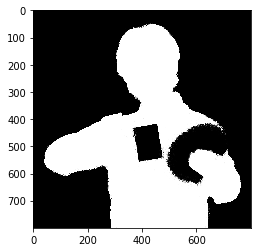

./dataset/Supervisely_person_dataset/ds6/alpha/pexels-photo-547593.jpeg
load
trimap
(800, 534)
(800, 534)
(800, 534)
Finding nearest neighbors
a [  0   0   0 ... 799 799 799]
b [  0   1   2 ... 531 532 533]
(427200, 10)
Computing sparse A
Solving linear system for alpha
matte


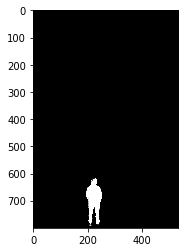

./dataset/Supervisely_person_dataset/ds6/alpha/pexels-photo-395245.jpeg
load
trimap
(800, 1200)
(800, 1200)
(800, 1200)
Finding nearest neighbors
a [  0   0   0 ... 799 799 799]
b [   0    1    2 ... 1197 1198 1199]
(960000, 10)
Computing sparse A
Solving linear system for alpha


In [ ]:
for ds in dslist:
    
    img_dir = os.path.join(DATASET_BASE, ds, "img")
    
    alpha_dir = os.path.join(DATASET_BASE, ds, "alpha")
    print(alpha_dir)

    if not os.path.exists(alpha_dir):
        os.mkdir(alpha_dir)
        
    img_list = [os.path.join(DATASET_BASE, ds, "img", i) for i in os.listdir(img_dir)]
    
    for img_path in img_list:
        
        img, mask = load_img_mask_pair(img_path)
        print("load")
        trimap = make_trimap(mask)
        print("trimap")
        alpha = knn_matte(img, trimap)
        print('matte')
        
        plt.imshow(alpha, cmap='gray')
        plt.show()
        
        alpha_path = img_path.replace("/img/", "/alpha/")

        save_alpha(alpha_path, alpha)
        print(alpha_path)
